In [192]:
import os
import random
import numpy as np
import pandas as pd
import os, json, joblib
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import polars as pl
from pathlib import Path
import warnings 
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import StratifiedGroupKFold
from scipy.spatial.transform import Rotation as R

In [193]:
# (Competition metric will only be imported when TRAINing)
TRAIN = True                     # ← set to True when you want to train
RAW_DIR = Path("C:\\Users\\konno\\SynologyDrive\\datasciense\\projects_foler\\1_kaggle\\CMI\\cmi-detect-behavior-with-sensor-data")

# used when TRAIN=False
PRETRAINED_DIR = Path("C:\\Users\\konno\\SynologyDrive\\datasciense\\projects_foler\\1_kaggle\\CMI\\cmi-detect-behavior-with-sensor-data\\pretrained-model")
EXPORT_DIR = PRETRAINED_DIR                                  # artefacts will be saved here
BATCH_SIZE = 256  #64
PAD_PERCENTILE = 95
LR_INIT =  5e-3  # too large 5e-2  okay 1e-2  improved 8e-3 
WD = 5e-4
MIXUP_ALPHA = 0.4
EPOCHS = 160 #160
PATIENCE = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print("▶ imports ready · torch", torch.__version__, "device :", device)

▶ imports ready · torch 2.7.1+cu128 device : cuda


In [194]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [195]:
def time_sum(x):
    return x.sum(dim=1)

def squeeze_last_axis(x):
    return x.squeeze(-1)

def expand_last_axis(x):
    return x.unsqueeze(-1)

class SEBlock1D(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        # x shape: (batch, channels, time)
        b, c, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1)
        return x * y.expand_as(x)

class ResidualSEBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pool_size=2, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SEBlock1D(out_channels)
        
        self.match_channels = None
        if in_channels != out_channels:
            self.match_channels = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        
        self.pool = nn.MaxPool1d(pool_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.se(out)

        if self.match_channels is not None:
            identity = self.match_channels(identity)
        
        out = F.relu(out + identity)
        out = self.pool(out)
        out = self.dropout(out)
        return out

class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attn_fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        # x shape: (batch, time, features)
        # Compute scores with tanh activation
        scores = torch.tanh(self.attn_fc(x))  # (batch, time, 1)
        scores = scores.squeeze(-1)           # (batch, time)

        # Softmax over time dimension to get weights
        weights = F.softmax(scores, dim=1)    # (batch, time)
        weights = weights.unsqueeze(-1)       # (batch, time, 1)

        # Weighted sum of input features over time
        context = (x * weights).sum(dim=1)    # (batch, features)
        return context

In [196]:
def preprocess_sequence(df_seq: pd.DataFrame, feature_cols: list[str], scaler: StandardScaler):
    mat = df_seq[feature_cols].ffill().bfill().fillna(0).values
    return scaler.transform(mat).astype('float32')

# MixUp the data argumentation in order to regularize the neural network. 

class MixupGenerator(Dataset):
    def __init__(self, X, y, alpha, time_cutmix=False, noise_std=0.03):
        """  
        X: np.array or totch.Tensor of shape (N, ...)
        y: np.array or torch.Tensor of shape (N, ...)
        alpha: Beta distribution parameter for mixup  0.2–0.4 is usually best. Smaller = more like original sample.
        time_cutmix: If True, apply temporal cutmix
        noise_std: Optional Gaussian noise after mixup  0.01–0.05 for noise injection.
        """
        self.X = torch.tensor(X, dtype=torch.float32) if isinstance(X, np.ndarray) else X
        self.y = torch.tensor(y, dtype=torch.float32) if isinstance(y, np.ndarray) else y
        self.alpha = alpha
        self.time_cutmix = time_cutmix
        self.noise_std = noise_std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        # Get current sample
        x1, y1 = self.X[index], self.y[index]

        # Choose a random other sample
        mix_index = np.random.randint(0, len(self.X))
        x2, y2 = self.X[mix_index], self.y[mix_index]

        # Mix them
        lam = np.random.beta(self.alpha, self.alpha)

        if self.time_cutmix:
            # Mix only over a time region
            T = x1.shape[0]
            cut_len = np.random.randint(T // 4, T // 2)
            t_start = np.random.randint(0, T - cut_len)
            x_mix = x1.clone()
            x_mix[t_start:t_start+cut_len] = x2[t_start:t_start+cut_len]
        else:
            x_mix = lam * x1 + (1 - lam) * x2

        y_mix = lam * y1 + (1 - lam) * y2

        if self.noise_std > 0:
            noise = torch.randn_like(x_mix) * self.noise_std
            x_mix += noise

        return x_mix, y_mix
    
# dataset = MixupGenerator(X_train, y_train, alpha=0.2)
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

def pad_or_truncate(seq, max_len, mode=TRAIN, pad_value=0.0, dtype=np.float32) -> np.ndarray:
    """
    Pads or truncates a sequence to a fixed length.

    Parameters:
    - seq: np.ndarray of shape (L, D)
    - max_len: int, desired sequence length
    - mode: bool, True = random pad, False = regular pad
    - pad_value: float or int, value to use for padding
    - dtype: np.dtype, dtype for the output array

    Returns:
    - np.ndarray of shape (max_len, D)
    """
    # print("sequence shape", seq.shape)
    L, D = seq.shape
    # print("mode = ", mode)

    if L > max_len:
        return seq[:max_len] # truncate if too long

    elif L < max_len:
        total_padding = max_len - L
        
        if mode:
            pad_start = np.random.randint(0, total_padding + 1)
            pad_end = total_padding - pad_start
            
        else:
            pad_start = 0
            pad_end = total_padding

        start_padding = np.full((pad_start, D), pad_value, dtype=dtype)
        end_padding = np.full((pad_end, D), pad_value, dtype=dtype)
        padded = np.vstack((start_padding, seq, end_padding))
        # print("padded shape", padded.shape)
        return padded

    else:
        return seq.astype(dtype)

In [197]:
def remove_gravity_from_acc(acc_data, rot_data):

    if isinstance(acc_data, pd.DataFrame):
        acc_values = acc_data[['acc_x', 'acc_y', 'acc_z']].values
    else:
        acc_values = acc_data

    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data

    num_samples = acc_values.shape[0]
    linear_accel = np.zeros_like(acc_values)
    
    gravity_world = np.array([0, 0, 9.81])

    for i in range(num_samples):
        if np.all(np.isnan(quat_values[i])) or np.all(np.isclose(quat_values[i], 0)):
            linear_accel[i, :] = acc_values[i, :] 
            continue

        try:
            rotation = R.from_quat(quat_values[i])
            gravity_sensor_frame = rotation.apply(gravity_world, inverse=True)
            linear_accel[i, :] = acc_values[i, :] - gravity_sensor_frame
        except ValueError:
             linear_accel[i, :] = acc_values[i, :]
             
    return linear_accel

def calculate_angular_velocity_from_quat(rot_data, time_delta=1/200): # Assuming 200Hz sampling rate
    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data

    num_samples = quat_values.shape[0]
    angular_vel = np.zeros((num_samples, 3))

    for i in range(num_samples - 1):
        q_t = quat_values[i]
        q_t_plus_dt = quat_values[i+1]

        if np.all(np.isnan(q_t)) or np.all(np.isclose(q_t, 0)) or \
           np.all(np.isnan(q_t_plus_dt)) or np.all(np.isclose(q_t_plus_dt, 0)):
            continue

        try:
            rot_t = R.from_quat(q_t)
            rot_t_plus_dt = R.from_quat(q_t_plus_dt)

            # Calculate the relative rotation
            delta_rot = rot_t.inv() * rot_t_plus_dt
            
            # Convert delta rotation to angular velocity vector
            # The rotation vector (Euler axis * angle) scaled by 1/dt
            # is a good approximation for small delta_rot
            angular_vel[i, :] = delta_rot.as_rotvec() / time_delta
        except ValueError:
            # If quaternion is invalid, angular velocity remains zero
            pass
            
    return angular_vel

def calculate_angular_distance(rot_data):
    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data

    num_samples = quat_values.shape[0]
    angular_dist = np.zeros(num_samples)

    for i in range(num_samples - 1):
        q1 = quat_values[i]
        q2 = quat_values[i+1]

        if np.all(np.isnan(q1)) or np.all(np.isclose(q1, 0)) or \
           np.all(np.isnan(q2)) or np.all(np.isclose(q2, 0)):
            angular_dist[i] = 0 # Или np.nan, в зависимости от желаемого поведения
            continue
        try:
            # Преобразование кватернионов в объекты Rotation
            r1 = R.from_quat(q1)
            r2 = R.from_quat(q2)

            # Вычисление углового расстояния: 2 * arccos(|real(p * q*)|)
            # где p* - сопряженный кватернион q
            # В scipy.spatial.transform.Rotation, r1.inv() * r2 дает относительное вращение.
            # Угол этого относительного вращения - это и есть угловое расстояние.
            relative_rotation = r1.inv() * r2
            
            # Угол rotation vector соответствует угловому расстоянию
            # Норма rotation vector - это угол в радианах
            angle = np.linalg.norm(relative_rotation.as_rotvec())
            angular_dist[i] = angle
        except ValueError:
            angular_dist[i] = 0 # В случае недействительных кватернионов
            pass
            
    return angular_dist

In [198]:
class TwoBranchGestureModel(nn.Module):
    def __init__(self, imu_dim, tof_dim, n_classes, wd=1e-4):
        super().__init__()
        self.imu_dim = imu_dim
        self.tof_dim = tof_dim
        
        # IMU deep branch
        self.imu_branch = nn.Sequential(
            ResidualSEBlock1D(imu_dim, 64, kernel_size=3, dropout=0.1),
            ResidualSEBlock1D(64, 128, kernel_size=5, dropout=0.1)
        )

        # TOF Lighter branch
        self.tof_branch = nn.Sequential(
            nn.Conv1d(tof_dim, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
        )

        # self.lstm = nn.LSTM(256, 128, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(256, 128, batch_first=True, bidirectional=True)

        # Gaussian noise (manual) and projection
        self.projection = nn.Sequential(
            nn.Dropout(0.09),
            nn.Linear(256, 16),
            nn.ELU()
        )

        self.pre_attn_dropout = nn.Dropout(0.4)
        self.attn = AttentionLayer(128*2 + 16)  #128*2 + 128*2 + 16

        # Dense layer
        self.mlp = nn.Sequential(
            nn.Linear(272, 128, bias=False),  #528
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0,3),
            nn.Linear(128, 64, bias=False),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes),  # Softmax handled by loss (e.g., CrossEntropyLoss)
        )
    
    def forward(self, x):
        imu = x[:, :, :self.imu_dim].permute(0, 2, 1) #(B, imu_dim, T)
        tof = x[: ,:, self.imu_dim:].permute(0, 2, 1) #(B, tof_dim, T)

        imu_feat = self.imu_branch(imu)
        tof_feat = self.tof_branch(tof)

        imu_feat = imu_feat.permute(0, 2, 1)
        tof_feat = tof_feat.permute(0, 2, 1)

        merged = torch.cat([imu_feat, tof_feat], dim=-1)  #(B, T', 256)

        # xa, _ = self.lstm(merged)  # → 256
        # xb, _ = self.gru(merged)  # → 256
        # xc = self.projection(merged)  # → 16

        x_seq, _ = self.gru(merged)  #(B, T', 256)
        x_proj = self.projection(merged)  #(B, T', 16)

        x_cat = torch.cat([x_seq, x_proj], dim=-1)  #(B, T', 272)
        x_cat = self.pre_attn_dropout(x_cat)
        context = self.attn(x_cat)  #(B, 272)

        return self.mlp(context)

In [199]:
### DATA CREATION
print("▶ TRAIN MODE – loading dataset …")
df = pd.read_csv(RAW_DIR / "train.csv")

train_dem_df = pd.read_csv(RAW_DIR / "train_demographics.csv")
df_for_groups = pd.merge(df.copy(), train_dem_df, on='subject', how='left')

le = LabelEncoder()
df['gesture_int'] = le.fit_transform(df['gesture'])
np.save(EXPORT_DIR / "gesture_classes.npy", le.classes_)
gesture_classes = le.classes_

print(" Calculating base engineered IMU features (magnitude, angle) ...")
df['acc_mag'] = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)
df['rot_angle'] = 2* np.arccos(df['rot_w'].clip(-1, 1))

print(" Calculating engineered IMU derivatives (jerk, angular velocity) for original acc_mag ...")
df['acc_mag_jerk'] = df.groupby('sequence_id')['acc_mag'].diff().fillna(0)
df['rot_angle_vel'] = df.groupby('sequence_id')['rot_angle'].diff().fillna(0)

print(" 6 Removing gravity and calculating linear acceleration features...")

linear_accel_list = []
for _, group in df.groupby('sequence_id'):
    acc_data_group = group[['acc_x', 'acc_y', 'acc_z']]
    rot_data_group = group[['rot_x', 'rot_y', 'rot_z', 'rot_w']]
    linear_accel_group = remove_gravity_from_acc(acc_data_group, rot_data_group)
    linear_accel_list.append(pd.DataFrame(linear_accel_group, columns=['linear_acc_x', 'linear_acc_y', 'linear_acc_z'], index=group.index))

df_linear_accel = pd.concat(linear_accel_list)
df = pd.concat([df, df_linear_accel], axis=1)

df['linear_acc_mag'] = np.sqrt(df['linear_acc_x']**2 + df['linear_acc_y']**2 + df['linear_acc_z']**2)
df['linear_acc_mag_jerk'] = df.groupby('sequence_id')['linear_acc_mag'].diff().fillna(0)

print(" 5 Calculating angular velocity from quaternion derivatives...")
angular_vel_list = []
for _, group in df.groupby('sequence_id'):
    rot_data_group = group[['rot_x', 'rot_y', 'rot_z', 'rot_w']]
    angular_vel_group = calculate_angular_velocity_from_quat(rot_data_group)
    angular_vel_list.append(pd.DataFrame(angular_vel_group, columns=['angular_vel_x', 'angular_vel_y', 'angular_vel_z'], index=group.index))

df_angular_vel = pd.concat(angular_vel_list)
df = pd.concat([df, df_angular_vel], axis=1)

print(" 4 Calculating angular distance between successive quaternions...")
angular_distance_list = []
for _, group in df.groupby('sequence_id'):
    rot_data_group = group[['rot_x', 'rot_y', 'rot_z', 'rot_w']]
    angular_dist_group = calculate_angular_distance(rot_data_group)
    angular_distance_list.append(pd.DataFrame(angular_dist_group, columns=['angular_distance'], index=group.index))

df_angular_distance = pd.concat(angular_distance_list)
df = pd.concat([df, df_angular_distance], axis=1)

meta_cols = { } # This was an empty dict in your provided code, keeping it as is.

imu_cols_base = ['linear_acc_x', 'linear_acc_y', 'linear_acc_z']
imu_cols_base.extend([c for c in df.columns if c.startswith('rot_') and c not in ['rot_angle', 'rot_angle_vel']])

imu_engineered_features = [
    'acc_mag', 'rot_angle',
    'acc_mag_jerk', 'rot_angle_vel',
    'linear_acc_mag', 'linear_acc_mag_jerk',
    'angular_vel_x', 'angular_vel_y', 'angular_vel_z', # Existing new features
    'angular_distance' # Added new feature
]
imu_cols = imu_cols_base + imu_engineered_features
imu_cols = list(dict.fromkeys(imu_cols)) # Для удаления дубликатов

thm_cols_original = [c for c in df.columns if c.startswith('thm_')]

## tof data
tof_aggregated_cols_template = []
for i in range(1, 6):
    tof_aggregated_cols_template.extend([f'tof_{i}_mean', f'tof_{i}_std', f'tof_{i}_min', f'tof_{i}_max'])

final_feature_cols = imu_cols + thm_cols_original + tof_aggregated_cols_template
imu_dim_final = len(imu_cols)
tof_thm_aggregated_dim_final = len(thm_cols_original) + len(tof_aggregated_cols_template)

print(f"  IMU (incl. engineered & derivatives) {imu_dim_final} | THM + Aggregated TOF {tof_thm_aggregated_dim_final} | total {len(final_feature_cols)} features")
np.save(EXPORT_DIR / "feature_cols.npy", np.array(final_feature_cols))

print(" 3 Building sequences with aggregated TOF and preparing data for scaler...")
seq_gp = df.groupby('sequence_id') 

all_steps_for_scaler_list = []
X_list_unscaled, y_list_int_for_stratify, lens = [], [], [] 

for seq_id, seq_df_orig in seq_gp:
    seq_df = seq_df_orig.copy()

    for i in range(1, 6):
        pixel_cols_tof = [f"tof_{i}_v{p}" for p in range(64)]
        tof_sensor_data = seq_df[pixel_cols_tof].replace(-1, np.nan)
        seq_df[f'tof_{i}_mean'] = tof_sensor_data.mean(axis=1)
        seq_df[f'tof_{i}_std']  = tof_sensor_data.std(axis=1)
        seq_df[f'tof_{i}_min']  = tof_sensor_data.min(axis=1)
        seq_df[f'tof_{i}_max']  = tof_sensor_data.max(axis=1)
    
    mat_unscaled = seq_df[final_feature_cols].ffill().bfill().fillna(0).values.astype('float32')
    
    all_steps_for_scaler_list.append(mat_unscaled)
    X_list_unscaled.append(mat_unscaled)
    y_list_int_for_stratify.append(seq_df['gesture_int'].iloc[0])
    lens.append(len(mat_unscaled))

# fit scaler
print(" 2 Fitting StandardScaler...")
all_steps_concatenated = np.concatenate(all_steps_for_scaler_list, axis=0)
scaler = StandardScaler().fit(all_steps_concatenated)
joblib.dump(scaler, EXPORT_DIR / "scaler.pkl")
del all_steps_for_scaler_list, all_steps_concatenated

# scale individual sequences
print(" 1 Scaling and padding sequences...")
X_scaled_list = [scaler.transform(x_seq) for x_seq in X_list_unscaled]
del X_list_unscaled

# calculate pad length
pad_len = int(np.percentile(lens, PAD_PERCENTILE))
np.save(EXPORT_DIR / "sequence_maxlen.npy", pad_len)

# padding section
X_padded_np = np.stack([pad_or_truncate(seq, pad_len) for seq in X_scaled_list])
X = torch.tensor(X_padded_np, dtype=torch.float32)  # shape: (N, T, D)
del X_scaled_list

y_int_for_stratify = np.array(y_list_int_for_stratify)
y = F.one_hot(torch.tensor(y_int_for_stratify), num_classes=len(le.classes_)).float()

print(" 0 Splitting data and preparing for training...")
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=82, stratify=y_int_for_stratify)

cw_vals = compute_class_weight('balanced', classes=np.arange(len(le.classes_)), y=y_int_for_stratify)

# Data Loader
train_dataset = MixupGenerator(X_tr, y_tr, alpha=0.2, time_cutmix=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MixupGenerator(X_val, y_val, alpha=0.2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("✅ Train completed")


▶ TRAIN MODE – loading dataset …
 Calculating base engineered IMU features (magnitude, angle) ...
 Calculating engineered IMU derivatives (jerk, angular velocity) for original acc_mag ...
 6 Removing gravity and calculating linear acceleration features...
 5 Calculating angular velocity from quaternion derivatives...
 4 Calculating angular distance between successive quaternions...
  IMU (incl. engineered & derivatives) 17 | THM + Aggregated TOF 25 | total 42 features
 3 Building sequences with aggregated TOF and preparing data for scaler...
 2 Fitting StandardScaler...
 1 Scaling and padding sequences...
 0 Splitting data and preparing for training...
✅ Train completed


In [200]:
model = TwoBranchGestureModel(imu_dim=imu_dim_final, tof_dim=tof_thm_aggregated_dim_final, n_classes=len(le.classes_))
model.to(device)

from torch.optim.lr_scheduler import ExponentialLR
optimizer = torch.optim.AdamW(model.parameters(), lr=LR_INIT, weight_decay=WD)
# scheduler = ExponentialLR(optimizer, gamma=0.95)  # T_max = number of epochs
weights_tensor = torch.tensor(cw_vals, dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

best_val_acc = 0
patience, patience_counter = 20, 0
EPOCHS = EPOCHS
counter = 0
ud = []
steps = []
lrs = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0         # <-- reset here
    total = 0           # <-- reset here
    for xb, yb in tqdm.tqdm(train_loader):
        xb, yb = xb.to(device), yb.to(device)
        if counter == 0:
            print(f"shape of xb :{xb.shape}")
            counter +=1
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # optional
        # Track parameter-wise update dynamixs
        with torch.no_grad():
            updates = []
            for p in model.parameters():
                if p.grad is not None and p.data.std() > 0:
                    ratio = (LR_INIT * p.grad.std() / (p.data.std() + 1e-8))
                    ud.append(ratio.log10().item())  # log10 for readability
                    
        optimizer.step()
        # scheduler.step()

        # accumulate train data
        total_loss += loss.item()
        # lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCH_SIZE + counter + 1)

        pred_labels = preds.argmax(dim=1)
        yb = yb.argmax(dim=1)
        correct += (pred_labels == yb).sum().item()
        total += yb.size(0)
    
    train_acc = correct / total
    print(f"Epoch {epoch} | Train Loss: {total_loss / len(train_loader):.4f} | Train Acc: {train_acc:.4f}")

    # Validation
    
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            pred_labels = preds.argmax(1)
            true_labels = yb.argmax(1)
            correct += (pred_labels == true_labels).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    print(f"Epoch {epoch} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'model.state_dict': model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'epoch': epoch
            }, EXPORT_DIR / "best_model.pt")
        print(f"Current Best Accuracy is {best_val_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
print(f"Best Accuracy was {best_val_acc:.4f}")


  0%|          | 0/26 [00:00<?, ?it/s]

shape of xb :torch.Size([256, 127, 42])


100%|██████████| 26/26 [00:01<00:00, 13.23it/s]


Epoch 0 | Train Loss: 2.4570 | Train Acc: 0.2695
Epoch 0 | Val Acc: 0.3844
Current Best Accuracy is 0.3844


100%|██████████| 26/26 [00:01<00:00, 16.93it/s]


Epoch 1 | Train Loss: 2.0088 | Train Acc: 0.4644
Epoch 1 | Val Acc: 0.5083
Current Best Accuracy is 0.5083


100%|██████████| 26/26 [00:01<00:00, 15.58it/s]


Epoch 2 | Train Loss: 1.8691 | Train Acc: 0.5460
Epoch 2 | Val Acc: 0.5763
Current Best Accuracy is 0.5763


100%|██████████| 26/26 [00:01<00:00, 16.52it/s]


Epoch 3 | Train Loss: 1.7851 | Train Acc: 0.5807
Epoch 3 | Val Acc: 0.5727


100%|██████████| 26/26 [00:01<00:00, 17.14it/s]


Epoch 4 | Train Loss: 1.7595 | Train Acc: 0.5980
Epoch 4 | Val Acc: 0.5690


100%|██████████| 26/26 [00:01<00:00, 16.44it/s]


Epoch 5 | Train Loss: 1.7396 | Train Acc: 0.6074
Epoch 5 | Val Acc: 0.5635


100%|██████████| 26/26 [00:01<00:00, 16.50it/s]


Epoch 6 | Train Loss: 1.6984 | Train Acc: 0.6304
Epoch 6 | Val Acc: 0.6131
Current Best Accuracy is 0.6131


100%|██████████| 26/26 [00:01<00:00, 16.52it/s]


Epoch 7 | Train Loss: 1.6573 | Train Acc: 0.6477
Epoch 7 | Val Acc: 0.6131


100%|██████████| 26/26 [00:01<00:00, 16.64it/s]


Epoch 8 | Train Loss: 1.6371 | Train Acc: 0.6581
Epoch 8 | Val Acc: 0.6076


100%|██████████| 26/26 [00:01<00:00, 16.66it/s]


Epoch 9 | Train Loss: 1.6242 | Train Acc: 0.6825
Epoch 9 | Val Acc: 0.6058


100%|██████████| 26/26 [00:01<00:00, 16.99it/s]


Epoch 10 | Train Loss: 1.6022 | Train Acc: 0.6906
Epoch 10 | Val Acc: 0.6278
Current Best Accuracy is 0.6278


100%|██████████| 26/26 [00:01<00:00, 16.88it/s]


Epoch 11 | Train Loss: 1.5915 | Train Acc: 0.7038
Epoch 11 | Val Acc: 0.6254


100%|██████████| 26/26 [00:01<00:00, 16.88it/s]


Epoch 12 | Train Loss: 1.5768 | Train Acc: 0.7035
Epoch 12 | Val Acc: 0.6180


100%|██████████| 26/26 [00:01<00:00, 16.43it/s]


Epoch 13 | Train Loss: 1.5486 | Train Acc: 0.7153
Epoch 13 | Val Acc: 0.6432
Current Best Accuracy is 0.6432


100%|██████████| 26/26 [00:01<00:00, 16.79it/s]


Epoch 14 | Train Loss: 1.5413 | Train Acc: 0.7287
Epoch 14 | Val Acc: 0.6757
Current Best Accuracy is 0.6757


100%|██████████| 26/26 [00:01<00:00, 16.64it/s]


Epoch 15 | Train Loss: 1.5067 | Train Acc: 0.7417
Epoch 15 | Val Acc: 0.6622


100%|██████████| 26/26 [00:01<00:00, 16.99it/s]


Epoch 16 | Train Loss: 1.5170 | Train Acc: 0.7463
Epoch 16 | Val Acc: 0.6603


100%|██████████| 26/26 [00:01<00:00, 16.73it/s]


Epoch 17 | Train Loss: 1.4774 | Train Acc: 0.7549
Epoch 17 | Val Acc: 0.6750


100%|██████████| 26/26 [00:01<00:00, 16.85it/s]


Epoch 18 | Train Loss: 1.4663 | Train Acc: 0.7730
Epoch 18 | Val Acc: 0.6695


100%|██████████| 26/26 [00:01<00:00, 16.74it/s]


Epoch 19 | Train Loss: 1.4768 | Train Acc: 0.7653
Epoch 19 | Val Acc: 0.6560


100%|██████████| 26/26 [00:01<00:00, 17.14it/s]


Epoch 20 | Train Loss: 1.4366 | Train Acc: 0.7779
Epoch 20 | Val Acc: 0.6603


100%|██████████| 26/26 [00:01<00:00, 16.60it/s]


Epoch 21 | Train Loss: 1.4277 | Train Acc: 0.7844
Epoch 21 | Val Acc: 0.6941
Current Best Accuracy is 0.6941


100%|██████████| 26/26 [00:01<00:00, 16.64it/s]


Epoch 22 | Train Loss: 1.4181 | Train Acc: 0.7883
Epoch 22 | Val Acc: 0.6763


100%|██████████| 26/26 [00:01<00:00, 16.96it/s]


Epoch 23 | Train Loss: 1.3981 | Train Acc: 0.7946
Epoch 23 | Val Acc: 0.6990
Current Best Accuracy is 0.6990


100%|██████████| 26/26 [00:01<00:00, 16.94it/s]


Epoch 24 | Train Loss: 1.3813 | Train Acc: 0.8067
Epoch 24 | Val Acc: 0.6867


100%|██████████| 26/26 [00:01<00:00, 16.44it/s]


Epoch 25 | Train Loss: 1.3846 | Train Acc: 0.8071
Epoch 25 | Val Acc: 0.6891


100%|██████████| 26/26 [00:01<00:00, 16.70it/s]


Epoch 26 | Train Loss: 1.3930 | Train Acc: 0.8118
Epoch 26 | Val Acc: 0.7155
Current Best Accuracy is 0.7155


100%|██████████| 26/26 [00:01<00:00, 16.58it/s]


Epoch 27 | Train Loss: 1.3777 | Train Acc: 0.8153
Epoch 27 | Val Acc: 0.7118


100%|██████████| 26/26 [00:01<00:00, 16.66it/s]


Epoch 28 | Train Loss: 1.3473 | Train Acc: 0.8242
Epoch 28 | Val Acc: 0.6885


100%|██████████| 26/26 [00:01<00:00, 16.59it/s]


Epoch 29 | Train Loss: 1.3582 | Train Acc: 0.8181
Epoch 29 | Val Acc: 0.7075


100%|██████████| 26/26 [00:01<00:00, 16.26it/s]


Epoch 30 | Train Loss: 1.3327 | Train Acc: 0.8344
Epoch 30 | Val Acc: 0.6836


100%|██████████| 26/26 [00:01<00:00, 16.23it/s]


Epoch 31 | Train Loss: 1.3308 | Train Acc: 0.8416
Epoch 31 | Val Acc: 0.6806


100%|██████████| 26/26 [00:01<00:00, 16.34it/s]


Epoch 32 | Train Loss: 1.3302 | Train Acc: 0.8363
Epoch 32 | Val Acc: 0.7106


100%|██████████| 26/26 [00:01<00:00, 15.80it/s]


Epoch 33 | Train Loss: 1.3229 | Train Acc: 0.8365
Epoch 33 | Val Acc: 0.6855


100%|██████████| 26/26 [00:01<00:00, 16.38it/s]


Epoch 34 | Train Loss: 1.3032 | Train Acc: 0.8498
Epoch 34 | Val Acc: 0.6732


100%|██████████| 26/26 [00:01<00:00, 16.29it/s]


Epoch 35 | Train Loss: 1.3124 | Train Acc: 0.8538
Epoch 35 | Val Acc: 0.7039


100%|██████████| 26/26 [00:01<00:00, 16.51it/s]


Epoch 36 | Train Loss: 1.3183 | Train Acc: 0.8434
Epoch 36 | Val Acc: 0.6971


100%|██████████| 26/26 [00:01<00:00, 16.26it/s]


Epoch 37 | Train Loss: 1.3088 | Train Acc: 0.8517
Epoch 37 | Val Acc: 0.6879


100%|██████████| 26/26 [00:01<00:00, 15.71it/s]


Epoch 38 | Train Loss: 1.3004 | Train Acc: 0.8548
Epoch 38 | Val Acc: 0.7094


100%|██████████| 26/26 [00:01<00:00, 16.04it/s]


Epoch 39 | Train Loss: 1.2859 | Train Acc: 0.8673
Epoch 39 | Val Acc: 0.7032


100%|██████████| 26/26 [00:01<00:00, 16.20it/s]


Epoch 40 | Train Loss: 1.2690 | Train Acc: 0.8704
Epoch 40 | Val Acc: 0.7210
Current Best Accuracy is 0.7210


100%|██████████| 26/26 [00:01<00:00, 15.95it/s]


Epoch 41 | Train Loss: 1.2736 | Train Acc: 0.8683
Epoch 41 | Val Acc: 0.6977


100%|██████████| 26/26 [00:01<00:00, 13.61it/s]


Epoch 42 | Train Loss: 1.2690 | Train Acc: 0.8712
Epoch 42 | Val Acc: 0.6910


100%|██████████| 26/26 [00:01<00:00, 13.32it/s]


Epoch 43 | Train Loss: 1.2762 | Train Acc: 0.8744
Epoch 43 | Val Acc: 0.7075


100%|██████████| 26/26 [00:01<00:00, 16.15it/s]


Epoch 44 | Train Loss: 1.2688 | Train Acc: 0.8722
Epoch 44 | Val Acc: 0.7100


100%|██████████| 26/26 [00:01<00:00, 16.39it/s]


Epoch 45 | Train Loss: 1.2624 | Train Acc: 0.8660
Epoch 45 | Val Acc: 0.7302
Current Best Accuracy is 0.7302


100%|██████████| 26/26 [00:02<00:00, 11.22it/s]


Epoch 46 | Train Loss: 1.2433 | Train Acc: 0.8844
Epoch 46 | Val Acc: 0.7124


100%|██████████| 26/26 [00:01<00:00, 15.25it/s]


Epoch 47 | Train Loss: 1.2402 | Train Acc: 0.8842
Epoch 47 | Val Acc: 0.6928


100%|██████████| 26/26 [00:01<00:00, 13.62it/s]


Epoch 48 | Train Loss: 1.2348 | Train Acc: 0.8911
Epoch 48 | Val Acc: 0.7039


100%|██████████| 26/26 [00:01<00:00, 14.87it/s]


Epoch 49 | Train Loss: 1.2397 | Train Acc: 0.8863
Epoch 49 | Val Acc: 0.7131


100%|██████████| 26/26 [00:02<00:00, 11.31it/s]


Epoch 50 | Train Loss: 1.2326 | Train Acc: 0.8902
Epoch 50 | Val Acc: 0.7045


100%|██████████| 26/26 [00:01<00:00, 14.51it/s]


Epoch 51 | Train Loss: 1.2366 | Train Acc: 0.8876
Epoch 51 | Val Acc: 0.7161


100%|██████████| 26/26 [00:01<00:00, 13.42it/s]


Epoch 52 | Train Loss: 1.2443 | Train Acc: 0.8837
Epoch 52 | Val Acc: 0.6990


100%|██████████| 26/26 [00:01<00:00, 13.37it/s]


Epoch 53 | Train Loss: 1.2491 | Train Acc: 0.8893
Epoch 53 | Val Acc: 0.7112


100%|██████████| 26/26 [00:02<00:00, 12.58it/s]


Epoch 54 | Train Loss: 1.2338 | Train Acc: 0.8933
Epoch 54 | Val Acc: 0.7229


100%|██████████| 26/26 [00:01<00:00, 13.89it/s]


Epoch 55 | Train Loss: 1.2368 | Train Acc: 0.8827
Epoch 55 | Val Acc: 0.7161


100%|██████████| 26/26 [00:01<00:00, 13.27it/s]


Epoch 56 | Train Loss: 1.2263 | Train Acc: 0.8859
Epoch 56 | Val Acc: 0.6996


100%|██████████| 26/26 [00:01<00:00, 13.42it/s]


Epoch 57 | Train Loss: 1.2218 | Train Acc: 0.8971
Epoch 57 | Val Acc: 0.7075


100%|██████████| 26/26 [00:01<00:00, 13.49it/s]


Epoch 58 | Train Loss: 1.2195 | Train Acc: 0.8980
Epoch 58 | Val Acc: 0.6812


100%|██████████| 26/26 [00:01<00:00, 13.22it/s]


Epoch 59 | Train Loss: 1.2340 | Train Acc: 0.8920
Epoch 59 | Val Acc: 0.7265


100%|██████████| 26/26 [00:01<00:00, 13.05it/s]


Epoch 60 | Train Loss: 1.2186 | Train Acc: 0.8945
Epoch 60 | Val Acc: 0.7443
Current Best Accuracy is 0.7443


100%|██████████| 26/26 [00:01<00:00, 14.59it/s]


Epoch 61 | Train Loss: 1.2154 | Train Acc: 0.8977
Epoch 61 | Val Acc: 0.7143


100%|██████████| 26/26 [00:01<00:00, 16.70it/s]


Epoch 62 | Train Loss: 1.2197 | Train Acc: 0.8942
Epoch 62 | Val Acc: 0.6959


100%|██████████| 26/26 [00:01<00:00, 13.59it/s]


Epoch 63 | Train Loss: 1.1980 | Train Acc: 0.8998
Epoch 63 | Val Acc: 0.7100


100%|██████████| 26/26 [00:01<00:00, 15.27it/s]


Epoch 64 | Train Loss: 1.1897 | Train Acc: 0.9058
Epoch 64 | Val Acc: 0.7088


100%|██████████| 26/26 [00:01<00:00, 16.51it/s]


Epoch 65 | Train Loss: 1.1987 | Train Acc: 0.9044
Epoch 65 | Val Acc: 0.7020


100%|██████████| 26/26 [00:01<00:00, 14.32it/s]


Epoch 66 | Train Loss: 1.1944 | Train Acc: 0.9037
Epoch 66 | Val Acc: 0.7155


100%|██████████| 26/26 [00:01<00:00, 13.02it/s]


Epoch 67 | Train Loss: 1.1832 | Train Acc: 0.9126
Epoch 67 | Val Acc: 0.7186


100%|██████████| 26/26 [00:01<00:00, 16.82it/s]


Epoch 68 | Train Loss: 1.2012 | Train Acc: 0.9002
Epoch 68 | Val Acc: 0.7198


100%|██████████| 26/26 [00:01<00:00, 17.12it/s]


Epoch 69 | Train Loss: 1.1869 | Train Acc: 0.9074
Epoch 69 | Val Acc: 0.7106


100%|██████████| 26/26 [00:01<00:00, 16.64it/s]


Epoch 70 | Train Loss: 1.1738 | Train Acc: 0.9160
Epoch 70 | Val Acc: 0.7186


100%|██████████| 26/26 [00:01<00:00, 14.30it/s]


Epoch 71 | Train Loss: 1.1948 | Train Acc: 0.9115
Epoch 71 | Val Acc: 0.7161


100%|██████████| 26/26 [00:01<00:00, 14.12it/s]


Epoch 72 | Train Loss: 1.1934 | Train Acc: 0.9087
Epoch 72 | Val Acc: 0.7296


100%|██████████| 26/26 [00:01<00:00, 15.06it/s]


Epoch 73 | Train Loss: 1.1799 | Train Acc: 0.9107
Epoch 73 | Val Acc: 0.7406


100%|██████████| 26/26 [00:01<00:00, 13.96it/s]


Epoch 74 | Train Loss: 1.1930 | Train Acc: 0.9061
Epoch 74 | Val Acc: 0.7333


100%|██████████| 26/26 [00:01<00:00, 14.36it/s]


Epoch 75 | Train Loss: 1.1780 | Train Acc: 0.9123
Epoch 75 | Val Acc: 0.6891


100%|██████████| 26/26 [00:01<00:00, 15.05it/s]


Epoch 76 | Train Loss: 1.1747 | Train Acc: 0.9152
Epoch 76 | Val Acc: 0.6830


100%|██████████| 26/26 [00:01<00:00, 13.68it/s]


Epoch 77 | Train Loss: 1.1783 | Train Acc: 0.9118
Epoch 77 | Val Acc: 0.6885


100%|██████████| 26/26 [00:01<00:00, 13.48it/s]


Epoch 78 | Train Loss: 1.1749 | Train Acc: 0.9120
Epoch 78 | Val Acc: 0.7063


100%|██████████| 26/26 [00:01<00:00, 15.67it/s]


Epoch 79 | Train Loss: 1.1669 | Train Acc: 0.9152
Epoch 79 | Val Acc: 0.7063


100%|██████████| 26/26 [00:01<00:00, 14.40it/s]


Epoch 80 | Train Loss: 1.1797 | Train Acc: 0.9190
Epoch 80 | Val Acc: 0.7124
Early stopping triggered.
Best Accuracy was 0.7443


SyntaxError: 'break' outside loop (899083737.py, line 5)

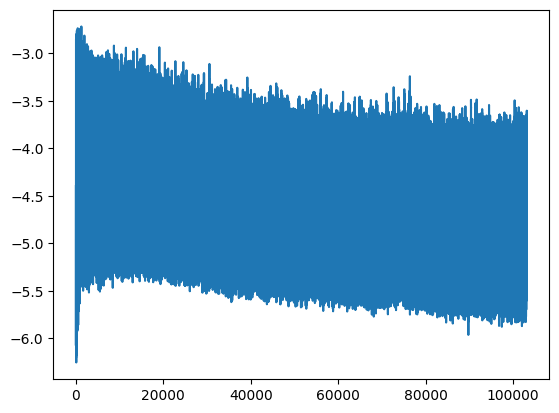

In [201]:
import matplotlib.pyplot as plt

plt.plot(ud)

break

checkpoint = torch.load(EXPORT_DIR / "checkpoint.pt")

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

best_val_acc = checkpoint['best_val_acc']
start_epoch = checkpoint['epoch'] + 1

In [ ]:
# Initialize at the start of training or epoch
ud_dict = {}  # key: layer name, value: list of ud values over time

# During training step
for name, p in model.named_parameters():
    if "layer_name" in name and p.grad is not None and p.data.std() > 0:
        ratio = (LR_INIT * p.grad.std() / (p.data.std() + 1e-8))
        log_ratio = ratio.log10().item()

        # Accumulate history per layer
        if name not in ud_dict:
            ud_dict[name] = []
        ud_dict[name].append(log_ratio)

import matplotlib.pyplot as plt

for layer_name, ud_values in ud_dict.items():
    plt.plot(ud_values, label=layer_name)

plt.xlabel("Training step or epoch")
plt.ylabel("log10(update/data ratio)")
plt.title("Update-to-Data Ratio per Layer")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load(EXPORT_DIR / "best_model.pt"))
model.eval()
preds_val = []

with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds_val.append(logits.argmax(1).cpu())

preds_val = torch.cat(preds_val).numpy()
true_val_int = y_val.argmax(1).numpy()

# Evaluation
from cmi_2025_metric_copy_for_import import CompetitionMetric

h_f1 = CompetitionMetric().calculate_hierarchical_f1(
    pd.DataFrame({'gesture': le.classes_[true_val_int]}),
    pd.DataFrame({'gesture': le.classes_[preds_val]})
)
print("Hold-out H-F1 =", round(h_f1, 4))

Hold-out H-F1 = 0.3496
